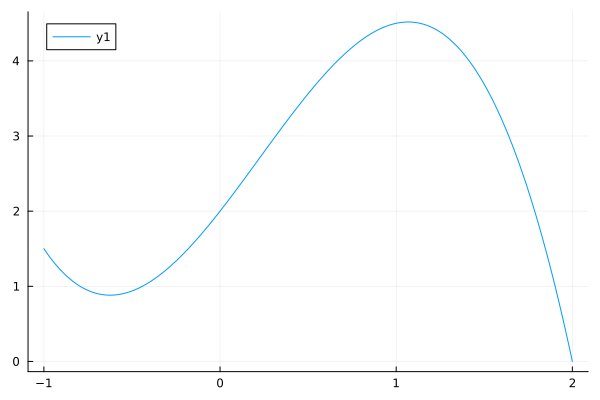

In [1]:
using LinearAlgebra
using Plots
using Random

function f(x, θ)
    powers = x.^(0:(length(θ)-1))
    return dot(powers, θ)
end

ts = -1.0:0.01:2.0
params = [2.0, 3.0, 1.0, -1.5]
ys = [f(t, params) for t in ts]
plot(ts, ys)

Funkcja celu:
$$
f_{cost}(\theta) = \sum_{i=1}^{N} (f(x_i; \theta) - y_i)^2
$$

Gradient funkcji celu:
$$
\nabla f_{cost}(\theta) = \sum_{i=1}^{N} 2(f(x_i; \theta) - y_i) \nabla f(x_i; \theta)
$$

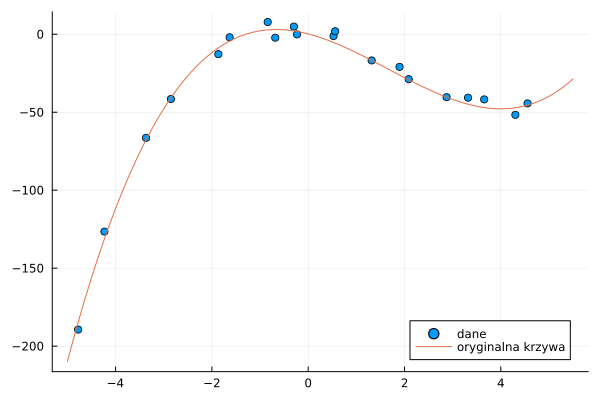

In [2]:
# Przykładowe dane
Random.seed!(15)
x_data = sort(randn(20).*3)
θ_data = [0.2, -8.0, -5.0, 1]
y_data = [f(x, θ_data) + randn()*4.0 for x in x_data]
scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")

In [3]:

struct CostF
    cost_x::Vector{Float64}
    cost_y::Vector{Float64}
end
(cf::CostF)(θ) = sum((map(x -> f(x, θ), cf.cost_x) - y_data).^2)

struct GradF
    cost_x::Vector{Float64}
    cost_y::Vector{Float64}
end
function (gf::GradF)(storage, θ)
    storage .= 0
    for i in eachindex(gf.cost_x)
        x = gf.cost_x[i]
        powers = x.^(0:(length(θ)-1))
        storage .+= 2 .* (dot(powers, θ) - gf.cost_y[i]) .* powers
    end
    return storage
end

cost_data = CostF(x_data, y_data)
grad_data = GradF(x_data, y_data)

grad_data(zeros(length(θ_data)), θ_data)

4-element Vector{Float64}:
  -46.049584295769534
  -76.20231751627733
 -118.40971000940743
 -656.334753978284

In [4]:
using Optim
using LineSearches
println(cost_data(randn(4)))


optim_res = optimize(cost_data, grad_data, randn(4), ConjugateGradient())

293774.17184253974


 * Status: success

 * Candidate solution
    Final objective value:     2.454184e+02

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.32e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.02e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.53e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.47e-16 ≰ 0.0e+00
    |g(x)|                 = 2.12e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    24
    ∇f(x) calls:   21


Znalezione wartości: [2.1099034080119834, -7.168612130975089, -5.113408939055918, 0.9598128371651404]
Funkja kosztu dla znalezionych: 245.4183705177865
Oryginalne wartości:  [0.2, -8.0, -5.0, 1.0]
Funkcja kosztu dla oryginalnych wartości: 301.1678650881249


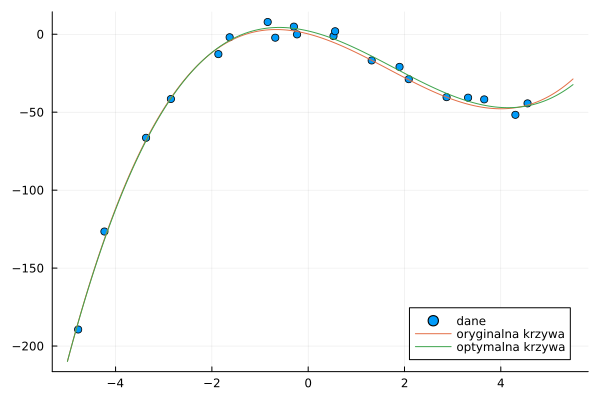

In [5]:
println("Znalezione wartości: $(optim_res.minimizer)")
println("Funkja kosztu dla znalezionych: $(optim_res.minimum)")
println("Oryginalne wartości:  $(θ_data)")
println("Funkcja kosztu dla oryginalnych wartości: $(cost_data(θ_data))")

scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")
plot!(t_plot, [f(x, optim_res.minimizer) for x in t_plot]; label="optymalna krzywa")

### Zadanie:

1. Napisz funkcję optymalizującą realizującą metodę największego spadku ze stałym krokiem. Spróbuj dobrać krok tak, aby problem regresji został rozwiązany w miarę dokładnie. Czy się udało?
2. Zamień stały krok na krok zanikający, t.j.
$$
\begin{align*}
\alpha_1 &= 1 \\
\alpha_k &= \gamma \alpha_{k-1}
\end{align*}
$$
dla pewnej stałej $\gamma \in (0,1]$, np. $\gamma = 0.9$ i porównaj działanie.

In [ ]:
function my_optimize(cost, grad, x0)
    res = optimize(cost, grad, x0, ConjugateGradient())
    return res.minimizer
end


opt = my_optimize(cost_data, grad_data, randn(4))
println(opt, cost_data(opt))
println("Cost = $(cost_data(opt))")

In [ ]:
# zadanie 1

function steepest_gradient_descent(cost, grad, x0, α; max_iter=10000, tol=1e-6)
    θ = copy(x0)
    storage = zeros(length(θ))
    for i in 1:max_iter
        value_start = cost(θ)
        storage = grad(storage, θ)
        θ_new = θ - α .* storage
        value_stop = cost(θ_new)
        println("grad: ", storage)
        println("θ: ", θ)
        println("θ_new: ", θ_new)
        println("Iteracja: ", i,"  start: ", value_start,"|||", value_stop)
        if value_stop - value_start > tol
            break
        else
            θ = θ_new
        end
    end
    return θ
end

opt = steepest_gradient_descent(cost_data, grad_data, randn(4), 0.00001)
println(opt, cost_data(opt))
scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")
plot!(t_plot, [f(x, opt) for x in t_plot]; label="optymalna krzywa")

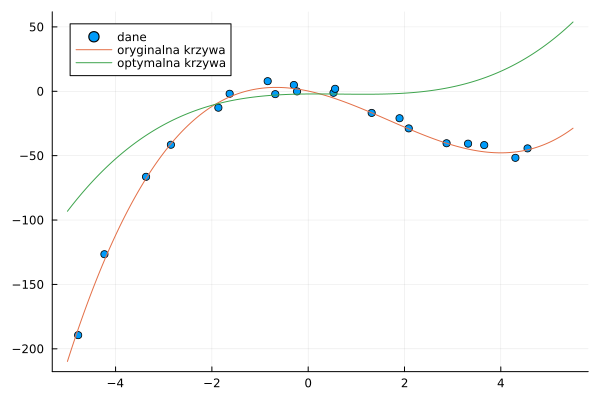

In [9]:
# zadanie 2

function steepest_gradient_descent_fading_step(cost, grad, x0, α, γ; max_iter=10000, tol=1e-6)
    θ = copy(x0)
    storage = zeros(length(θ))
    for i in 1:max_iter
        value_start = cost(θ)
        strorage = grad(storage, θ)
        θ_new = θ - α .* storage
        value_stop = cost(θ_new)
        println("grad: ", storage)
        println("θ: ", θ)
        println("θ_new: ", θ_new)
        println("α: ", α)
        println("Iteracja: ", i,"  start: ", value_start,"|||", value_stop)
        if value_stop - value_start > tol
            break
        else
            θ = θ_new
            α *= γ
        end
    end
    return θ
end

opt2 = steepest_gradient_descent_fading_step(cost_data, grad_data, randn(4), 0.00001, 0.9)
println(opt2, cost_data(opt2))
scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")
plot!(t_plot, [f(x, opt2) for x in t_plot]; label="optymalna krzywa")

Skąd wiedzieć, czy nasz gradient jest poprawny?
Możemy wykonać test.

In [ ]:
using Manopt, Manifolds
(cf::CostF)(::Euclidean, θ) = cf(θ)
(gf::GradF)(::Euclidean, θ) = gf(similar(θ), θ)
check_gradient(Euclidean(4), cost_data, grad_data, plot=true)